In [11]:
import json
import cv2
import numpy as np
import subprocess
import os
import allin1
from tqdm import tqdm

/home/keli/VideoEdit/.oldvenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def generate_video_with_cuts(plan, output_path="output_with_cuts.mp4", fps=30, music_path=None):
    """
    根据剪切点生成视频，画面显示剪切点位置，并添加音频。

    参数：
        plan (list): 剪辑点规划列表。
        output_path (str): 输出视频路径。
        fps (int): 视频帧率。
        music_path (str): 音频文件路径。
    """
            
    temp_video_path = "temp_video.mp4"
    width, height = 640, 480  # 固定视频分辨率
    cut_points = [(point, f"{segment['label']} {segment['strength']}") for segment in plan for point in segment['cut_point']]
    # 获取音频长度
    if music_path:
        result = subprocess.run(
            ["ffprobe", "-v", "error", "-show_entries",
             "format=duration", "-of",
             "default=noprint_wrappers=1:nokey=1", music_path],
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT
        )
        audio_duration = float(result.stdout)
        print(f"音频长度: {audio_duration} 秒")
    else:
        audio_duration = 30.0  # 默认视频长度为30秒

    total_frames = int(audio_duration * fps)

    # 初始化视频写入器
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(temp_video_path, fourcc, fps, (width, height))

    # 将剪切点转换为帧号
    cut_frames = [int(cut * fps) for cut, _ in cut_points]

    color_toggle = True  # 初始颜色标志
    text = ""
    for frame_idx in tqdm(range(total_frames)):
        # 每个剪切点切换一次颜色
        if frame_idx in cut_frames:
            color_toggle = not color_toggle
            text = cut_points[cut_frames.index(frame_idx)][1]

        # 根据颜色标志设置背景颜色
        if color_toggle:
            frame = np.full((height, width, 3), (135, 206, 250), dtype=np.uint8)
        else:
            frame = np.full((height, width, 3), (240, 128, 128), dtype=np.uint8)

        # 在帧上绘制剪切点文本
        cv2.putText(frame, f"label: {text}", (50, height // 2), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

        # 写入帧
        out.write(frame)

    # 释放资源
    out.release()


    # 如果提供了音频文件，合成音频和视频
    if music_path:
        command = [
            "ffmpeg", "-y", "-i", temp_video_path, "-i", music_path, "-c:v", "copy", "-c:a", "aac", "-strict", "experimental", output_path
        ]
        subprocess.run(command, check=True)
        print(f"生成视频已保存到 {output_path}，并添加了音频 {music_path}")
        # 删除临时视频文件
        if os.path.exists(temp_video_path):
            os.remove(temp_video_path)
    else:
        os.rename(temp_video_path, output_path)
        print(f"生成视频已保存到 {output_path}")

In [9]:
from src.utils.path import get_output_dir

In [8]:
music_path = "data/musics/04 - Survive.mp3"

In [10]:
cache_dir = get_output_dir() / "musics"
cache_file = cache_dir / f"{os.path.basename(music_path).split('.')[0]}.json"

In [12]:
result = allin1.load_result(cache_file)

In [20]:
cutpoint_path = "./tools/temp4.json"

In [21]:
with open(cutpoint_path, "r") as f:
    data = json.load(f)
    plan = data['plan']
    music_path = data['music']

In [22]:
cut_points = [(point, f"{segment['label']} {segment['strength']}") for segment in plan for point in segment['cut_point']]

/home/keli/VideoEdit/.oldvenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/keli/VideoEdit/.oldvenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/keli/VideoEdit/.oldvenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/keli/VideoEdit/.oldvenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38548 (\N{CJK UNIFIED IDEOGRAPH-9694}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/keli/VideoEdit/.oldvenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarni

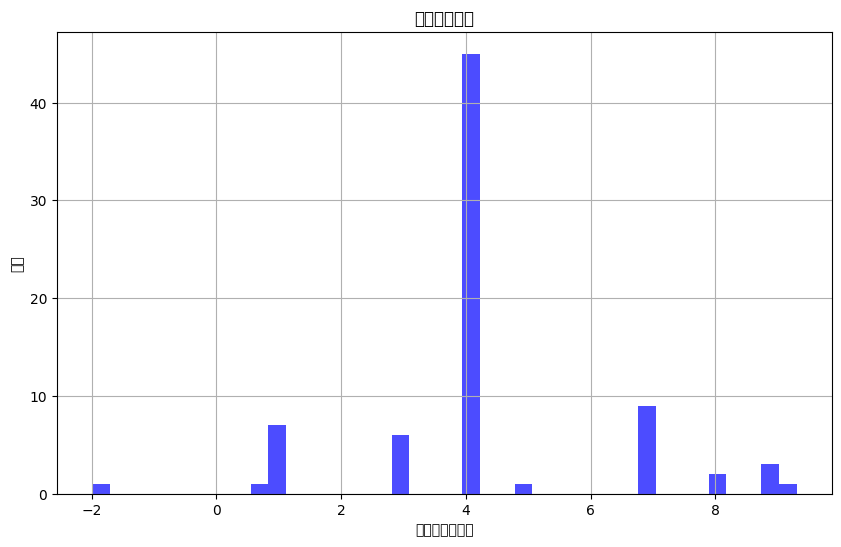

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
 
# 计算间隔距离
intervals = np.diff([point for point, _ in cut_points]) / (60 / result.bpm)  # 转换为拍数
 
# 绘制间隔距离分布
plt.figure(figsize=(10, 6))
plt.hist(intervals, bins=40, color='blue', alpha=0.7)
plt.title('间隔距离分布')
plt.xlabel('间隔距离（拍）')
plt.ylabel('频率')
plt.grid(True)
plt.show()